Mostly based on this method https://docs.opencv.org/3.4/d3/db4/tutorial_py_watershed.html

In [6]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage.filters import threshold_yen
import cv2
import math
im=cv2.imread('test_image.tif')
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

## Thresholding

In [18]:
thresh = threshold_yen(gray)
binary = gray > thresh*0.98

## Closing white dots

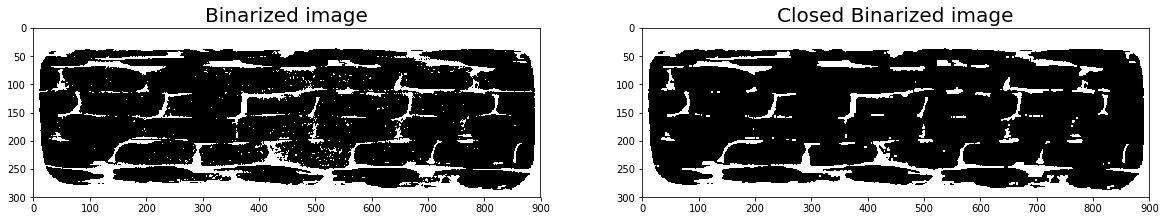

In [19]:
kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(np.uint8(binary),cv2.MORPH_CLOSE,kernel)

f ,(ax1,ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.set_title('Binarized image',size=20)
ax1.imshow(binary,cmap='Greys')
ax2.set_title('Closed Binarized image',size=20)
ax2.imshow(closing,cmap='Greys')

## Getting the sure background areas

In [20]:
sure_bg = cv2.dilate(closing,kernel,iterations=2)
sure_bg = cv2.bitwise_not(sure_bg)

## Getting the distance map

to better separate the fibers, we use the distance transform with a distance function as such:
$d((x_1,y_1),(x_2,y_2))=|x_1-x_2|+\alpha{|y_1-y_2|}$ where $\alpha$ is a parameter of the model.
This will let the value in the distance image of points from upper and lower edges to be greater lower than that of the points of left or right edges of each fibers which will hopefully let us enhance the horizontal separation when thresholding the distance image.

In [21]:
alpha = 10

def distance(x1,y1,x2,y2):
    return abs(x1-x2)+alpha*abs(y1-y2)

vect_distance = np.vectorize(distance)

In [22]:
indices_distance = ndi.distance_transform_edt(closing,return_distances=False,return_indices=True)
indices_distance_lignes = indices_distance[0]
indices_distance_colonnes = indices_distance[1]

indices_base = np.indices(closing.shape)
indices_base_ligne = indices_base[0]
indices_base_colonnes = indices_base[1]

distance = vect_distance(indices_base_colonnes,indices_base_ligne,
                         indices_distance_colonnes,indices_distance_lignes)

### Thresholding the distance map

In [42]:
thresh_on_distance = 0.32*distance.max()
sure_fg = distance > thresh_on_distance

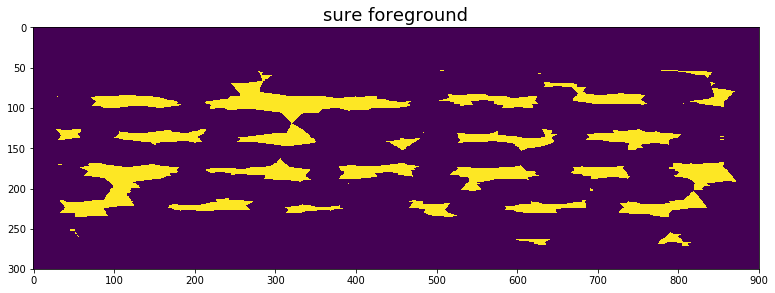

In [43]:
f,ax = plt.subplots(1,1,figsize=(13,13))
ax.set_title('sure foreground', size=18)
ax.imshow(sure_fg)

## Getting regions with unknow status

In [44]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

## Using watershed segmentation on the above information

Each connected component of the sure_foreground map above get a label in the markers map ( from 2 to n+1, if n connected components in the sure_fg image).
The sure_background part also has a label his own (1), and the unknown part is labeled 0

In [45]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==254]=0

markers = cv2.watershed(im,markers)

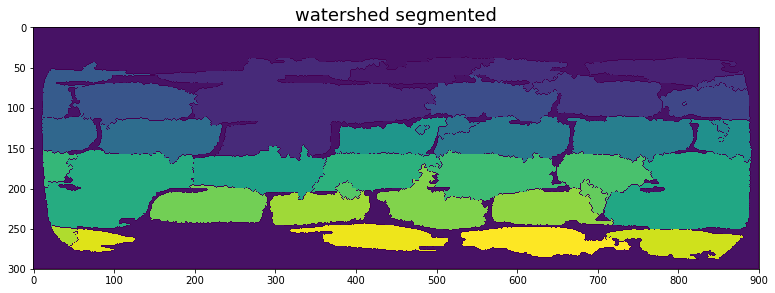

In [46]:
f,ax = plt.subplots(1,1,figsize=(13,13))
ax.set_title('watershed segmented',size=18)
ax.imshow(markers)